In [ ]:
#default_exp experiments
from nbdev.showdoc import show_doc

In [ ]:
%load_ext autoreload
%autoreload 2
from pwc_gabor_layer.core import GaborLayer
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## First load mnist 

Data processing as in the tensorflow datasets tutorial, this is just for an example. And more specifically for fixing issues with backpropagtion!

In [ ]:
(ds_train, ds_test), ds_info = tfds.load('mnist', split=['train', 'test'], shuffle_files=True, 
                         as_supervised=True, with_info=True)

def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

Some MNIST examples.

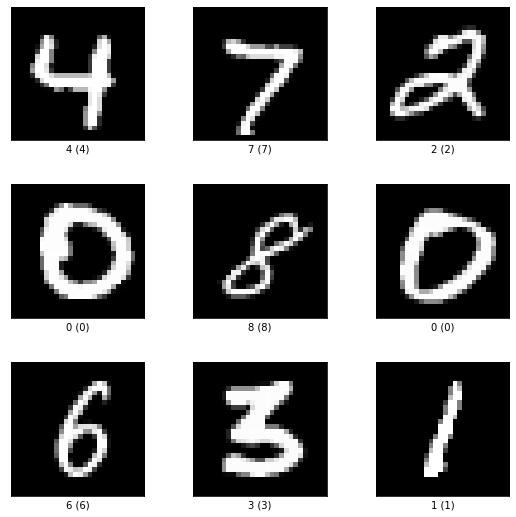

In [ ]:
# tfds.show_examples does not go with supervised features
ds_viz, viz_info = tfds.load('mnist', split='test', shuffle_files=True, 
                         as_supervised=False, with_info=True)

tfds.show_examples(ds_viz, viz_info);

# Some settings for later
ds_viz = ds_viz.batch(16)
ds_viz = ds_viz.cache()

## Apply kernel to MNIST

In [ ]:
GL = GaborLayer(filters=2, kernel_size=(7, 7), orientations=8, use_alphas=False, activation=None)
GL.build([None, 28, 28, 1])

Get a single element of MNIST dataset

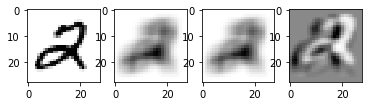

In [ ]:
one_batch = np.stack(list(ds_viz))[0]['image']

blub = GL.call(tf.cast(one_batch[:1, :, :, :]/255, tf.float32))

n1 = 6; n2 = n1 + 1

plt.subplot(141)
plt.imshow(one_batch[0,:,:,0], cmap='Greys')
plt.subplot(142)
plt.imshow(blub[0, :, :, n1], cmap='Greys')
plt.subplot(143)
plt.imshow(blub[0, :, :, n2], cmap='Greys')
plt.subplot(144)
plt.imshow(blub[0, :, :, n1]-blub[0, :, :, n2], cmap='Greys')

In [ ]:
GL.kernel

<tf.Tensor: shape=(16, 7, 7, 1), dtype=float32, numpy=
array([[[[0.99895924],
         [0.99972427],
         [0.99969953],
         [0.9988847 ],
         [0.9972806 ],
         [0.99488896],
         [0.9917127 ]],

        [[0.9989594 ],
         [0.99972445],
         [0.99969965],
         [0.99888486],
         [0.9972807 ],
         [0.99488914],
         [0.99171287]],

        [[0.99895954],
         [0.99972457],
         [0.9996998 ],
         [0.9988849 ],
         [0.99728084],
         [0.99488926],
         [0.991713  ]],

        [[0.99895954],
         [0.99972457],
         [0.99969983],
         [0.998885  ],
         [0.9972809 ],
         [0.99488926],
         [0.991713  ]],

        [[0.99895954],
         [0.99972457],
         [0.9996998 ],
         [0.9988849 ],
         [0.99728084],
         [0.99488926],
         [0.991713  ]],

        [[0.9989594 ],
         [0.99972445],
         [0.99969965],
         [0.99888486],
         [0.9972807 ],
         [0.994

In [ ]:
test_gl =  GaborLayer(filters=2, kernel_size=(7,7), orientations=8, activation='relu')
model = keras.models.Sequential([
                        keras.layers.Input([28, 28, 1]),
                        test_gl,
                         keras.layers.Flatten(),
                        keras.layers.Dense(10, activation='softmax')])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gabor_layer_4 (GaborLayer)   (None, 28, 28, 16)        832       
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                125450    
Total params: 126,282
Trainable params: 125,490
Non-trainable params: 792
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy', metrics='accuracy')

In [ ]:
model.fit(ds_train, validation_data=ds_test)

469/469 [==============================] - 12s 26ms/step - loss: 9.9754 - accuracy: 0.0979 - val_loss: 9.9150 - val_accuracy: 0.1028


In [ ]:
tf.reduce_mean(tf.abs(blub[0, :, :, 2] - blub[0, :, :, 3]))

<tf.Tensor: shape=(), dtype=float32, numpy=1.0342307>

In [ ]:
test_gl.bias

<tf.Variable 'gabor_layer_14/bias:0' shape=(16,) dtype=float32, numpy=
array([ 0.        , -0.39217412, -0.02059476,  0.        , -0.4233644 ,
        0.        ,  0.        ,  0.        , -0.23332134,  0.        ,
        0.        ,  0.        ,  0.        , -0.4152614 , -0.4087475 ,
        0.        ], dtype=float32)>

In [ ]:
kernel = tf.transpose(GL.kernel, [1, 2, 3, 0])

kernel = tf.repeat(kernel, 2, axis=2)


1

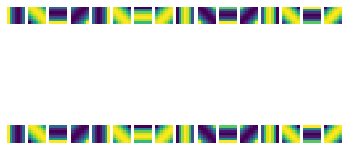

In [ ]:
fig, axes = plt.subplots(2, 16)

for n, ax in enumerate(axes.flatten()):
    ax.imshow(kernel[:,:,n//16,np.mod(n, 16)])
    ax.axis('off')